In [4]:
"""
6. 앙상블
    -여러개의 분류 모델을 조합해서 더 나은 성능을 내는 방법
    
    (1). [이론] 배깅
        - 과대적합되기 쉬운 모델에 적합한 앙상블
        - 한가지 분류 모델을 여러개 만들어서 서로 다른 학습 데이터를 학습시킨 후(부트스트랩), 동일한 테스트 데이터에 대한 서로 다른 예측값들을 투표를 통해(어그리게이팅) 가장 높은 예측값으로 결론을 내리는 기법
        
        (i) 부트스트랩
            - 데이터를 조금은 편향되도록 샘플링함으로써 분산이 높은 모델의 과대적합 위험을 줄임 ; 과대적합된 모델 = 분산은 높고 편향은 적음
            - N개의 데이터를 K개로 나누어 K개의 의사결정트리로 학습 -> N개의 데이터를 하나의 의사결정트리로 학습했을 때 보다 편향이 높아 과대적합될 확률이 적어짐
            - 샘플링 데이터는 보통 전체데이터의 60~70% 사용
        
        (ii) 어그리게이팅
            - 여러 분류모델이 예측한 값들을 조합해서 하나의 결론을 도출하는 과정 - > 투표로 진행
        
        (iii) 하드보팅
            - 단순히 최다 득표를 받은 값을 결론으로 도출
        
        (iv) 소프트보팅
            - 하드보팅보다 더 정교한 방식, 각 분류값별 확률을 더해준 값을 점수로 사용해 최대 점수를 가진 분류값을 결론으로 도출
            
        (v) 랜덤 포레스트
            - 여러 의사결정 트리를 배깅해서 예측을 실행하는 모델
            - 여러개의 나무들이 모여있다는 개념에서 랜덤 포레스트라고 부름
            - 의사결정 트리에서는 최적의 특징으로 트리를 분기하는 반면, 랜덤 포레스트는 각 노드에 주어진 데이터를 샘플링해서 일부 데이터를 제외한 채 최적의 특징을 찾아 트리를 분기 -> 또 한번 모델의 편향을 증가시켜 과대적합의 위험을 감소시킴
            
    (2). [이론] 부스팅
        - 여러개의 분류기를 만들어 투표를 통해 예측값을 결정한다는 측면에서 배깅과 동일
        - 배깅과는 달리 부스팅은 동일한 알고리즘 분류기를 순차적으로 학습해서 여러개의 분류기를 만든 후 테스트 할 때 가중 투표를 통해 예측값을 결정
        
        (i) 순차적 학습
            - ex) 인물 사진을 보고 남자/여자로 분류하는 의사결정 트리를 부스팅 할 경우 첫번째 의사결정 트리 학습 -> 남자 분류가 미흡할 경우 남자 학습 데이터를 보강 후 두번째 의사결정 트리 학습 -> 세번째 학습 ...
            
        (ii) 가중 투표
            - 각 분류기가 가지는 정확도에 따라 가중 투표가 이루어짐
            - 하드보팅/소프트 보팅 적용 가능
        
"""

#3.[실습] 랜덤 포레스트 손글씨 분류 - MNIST 손글씨 데이터셋 활용
from sklearn import datasets
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#손글씨 데이터 불러오기
mnist = datasets.load_digits()
features, labels = mnist.data, mnist.target

In [8]:
#교차 검증 - MNIST 데이터에 대한 랜덤 포레스트와 의사결정 트리의 검증 정확도 확인, 교차 검증 10번 수행해서 10번의 검증 정확도를 리스트에 저장
def cross_validation(classifier, features, labels):
    cv_scores = []
    for i in range(10):
        scores = cross_val_score(classifier, features, labels, cv=10, scoring = 'accuracy')
        cv_scores.append(scores.mean())
    return cv_scores

#의사결정틀의 MNIST 손글씨 검증 정확도 저장
dt_cv_scores = cross_validation(tree.DecisionTreeClassifier(), features, labels)


In [9]:
#랜덤 포레스트의 MNIST 손글씨 검증 정확도 저장
rf_cv_scores = cross_validation(RandomForestClassifier(), features, labels)

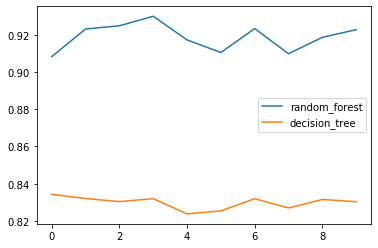

In [10]:
#랜덤 포레스트 vs 의사결정 트리의 정확도 시각화
cv_list = [
    ['random_forest', rf_cv_scores],
    ['decision_tree',dt_cv_scores],
]
df = pd.DataFrame.from_items(cv_list)
df.plot()

In [12]:
#정확도
#의사결정트리의 정확도
np.mean(dt_cv_scores)

0.8298676589907444

In [13]:
#랜덤 포레스트의 정확도
np.mean(rf_cv_scores)

0.9188569694303954

In [15]:
#4.[실습] 보팅 앙상블 손글씨 분류
#단일 모델들을 앙상블해서 투표를 통해 예측

from sklearn import datasets
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#손글씨 데이터 불러오기
mnist = datasets.load_digits()
features,labels = mnist.data, mnist.target
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2)

#단일 모델의 정확도 측정
#의사결정 트리
dtree = tree.DecisionTreeClassifier(criterion='gini',max_depth=8,max_features=32,random_state=35)
dtree = dtree.fit(X_train, y_train)
dtree_predicted = dtree.predict(X_test)

#kNN 모델
knn = KNeighborsClassifier(n_neighbors=299).fit(X_train,y_train)
knn_predicted = knn.predict(X_test)

#SVM
svm = SVC(C=0.1, gamma=0.003, probability = True, random_state=35).fit(X_train, y_train)
svm_predicted = svm.predict(X_test)

print("[accuracy']")
print("d-tree:", accuracy_score(y_test, dtree_predicted))
print("knn   :", accuracy_score(y_test, knn_predicted))
print("svm   :", accuracy_score(y_test, svm_predicted))

[accuracy']
d-tree: 0.8388888888888889
knn   : 0.8361111111111111
svm   : 0.8472222222222222


In [16]:
#분류값별 확률 확인
#소프트보팅, 하드보팅 -> 사이킷런의 voting_classifier 사용
# 직접 소프트 보팅을 구현할 때는 predict_proba 함수를 사용, 수행할 때 측정된 분류값별 확률 사용

svm_proba = svm.predict_proba(X_test)
print(svm_proba[0:2]) # 첫 두 숫자의 확률 출력
#결과를 보면 첫번째 숫자는 99.99%의 확률로 0으로 예측, 두번째 숫자는 68.2%의 확률로 5로 예측

[[9.99981218e-01 1.25103578e-06 8.14599024e-07 1.04586137e-06
  7.72590059e-07 8.79943555e-07 8.49057043e-06 2.09805712e-06
  1.66636989e-06 1.76298236e-06]
 [8.19469607e-03 2.65936510e-02 1.84258044e-02 2.43833214e-02
  1.84740865e-02 6.82046077e-01 1.12897564e-02 3.03446270e-02
  1.08058167e-01 7.21898138e-02]]


In [17]:
#하드 보팅
voting_clf = VotingClassifier(estimators=[
    ('decision_tree',dtree), ('knn', knn), ('svm', svm)],
    weights=[1,1,1], voting='hard').fit(X_train,y_train)

hard_voting_predicted = voting_clf.predict(X_test)
accuracy_score(y_test, hard_voting_predicted)

C:\Users\1\anaconda3\envs\virtualtensor3.6\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8972222222222223

In [25]:
#소프트 보팅 - 각 분류모델의 predict_proba를 활용, 모든 분류값들의 확률을 더해 가장 높은 점수를 획득한 분류값으로 결론을 내리는 방식
voting_clf = VotingClassifier(estimators=[('decision_tree',dtree), ('knn', knn), ('svm', svm)], weights=[1,1,1], voting = 'soft').fit(X_train, y_train)
soft_voting_predicted = voting_clf.predict(X_test)
accuracy_score(y_test, soft_voting_predicted)

C:\Users\1\anaconda3\envs\virtualtensor3.6\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9138888888888889

([<matplotlib.axis.XTick at 0x1550f6683c8>,
 <a list of 5 Text xticklabel objects>)

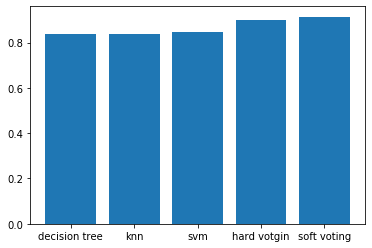

In [26]:
#단일 모델과 앙상블 모델의 정확도 비교 시각화
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.arange(5)
plt.bar(x, height = [
    accuracy_score(y_test, dtree_predicted),
    accuracy_score(y_test, knn_predicted),
    accuracy_score(y_test, svm_predicted),
    accuracy_score(y_test, hard_voting_predicted),
    accuracy_score(y_test, soft_voting_predicted)
])

plt.xticks(x, ['decision tree', 'knn', 'svm', 'hard votgin', 'soft voting'])
# 결과를 보면 보팅이 단일보다 더 낫지만 항상 그런 것은 아니니 주의

In [27]:
"""
7. 군집화
    - 비지도학습 알고리즘의 일종으로, 데이터 특징만으로 비슷한 데이터들끼리 모아 군집된 클래스로 분류
    
    (1).[이론] k평균 알고리즘
        - 다음과 같은 순서로 결정 :
            1) 데이터 준비
            2) 몇 개의 클래스로 분류할 것인지 설정
            3) 클러스터의 최초 중심 설절
            4) 데이터를 가장 가까운 클러스터로 지정
            5) 클러스터 중심을 클러스터에 속한 데이터들의 가운데 위치로 변경
            6) 클러스터 중심이 바뀌지 않을 때까지 4번부터 5번 과정을 반복
            
        (i) 데이터 준비
            -데이터는 수치화 된 데이터여야 함
        
        (ii) 몇 개의 클래스로 분류할 것인지 분류
            - k 평균 알고리즘의 k가 몇개의 클래스로 분류할 것인지 나타내는 변수
            
        (iii) 클러스터의 최초 중심 설정
            - k평균 알고리즘은 클러스터의 최초 중심을 무작위로 선정하지만 때때로 최초 중심을 부여할 수 있음
            - 사이킷런의 k 평균 라이브러리는 기본적으로 kmean++라는 알고리즘 이용 -> 최초데이터 포인트를 첫번째 중심, 그와 가장 먼 데이터를 두번째 중심, 두번째와 가자 먼 데이터를 세번째 중심 ...
            - kmean++는 초기 중심이 한군데로 집약되어 있어 군집하는데 시간이 오래 걸리고 군집의 결과가 나쁜 경우가 많은 표준 k 평균 알고리즘의 랜덤 중심 설정의 단점을 보완하고자 만들어짐
            
        (iv) 데이터를 가장 가까운 클러스터로 설정/ 클러스터 중심을 클러스터에 속한 데이터들의 가운데 위치로 변경/ 클러스터 중심이 바뀌지 않을 때 까지 반복
            
            
"""

#(2). [실습] 키와 몸무게에 따른 체형 군집화

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#데이터 만들기
df = pd.DataFrame(columns=['height', 'weight'])
df.loc[0] = [185,60]
df.loc[1] = [180,60]
df.loc[2] = [185,70]
df.loc[3] = [165,63]
df.loc[4] = [155,68]
df.loc[5] = [170,75]
df.loc[6] = [175,80]

df.head()

,height,weight
0,185,60
1,180,60
2,185,70
3,165,63
4,155,68


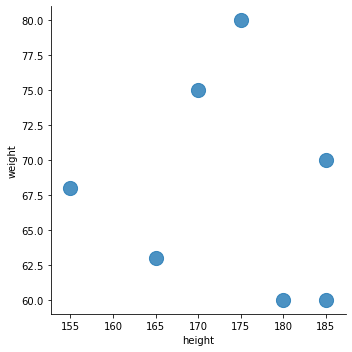

In [30]:
#데이터 시각화
sns.lmplot('height','weight',data=df, fit_reg = False, scatter_kws={"s":200})

In [35]:
# k 평균 군집
data_points = df.values
kmeans = KMeans(n_clusters=3).fit(data_points) # 별도의 init 파라미터를 지정하지 않으면 kmean++를 토해 군집수행

In [37]:
#각 군집의 중심위치 확인
kmeans.cluster_centers_

array([[183.33333333,  63.33333333],
       [172.5       ,  77.5       ],
       [160.        ,  65.5       ]])

In [38]:
#데이터가 어느 군집에 위치해 있는지 저장
df['cluster_id'] = kmeans.labels_

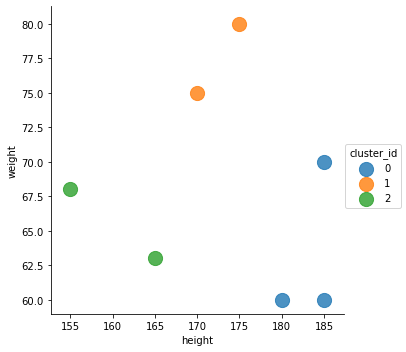

In [39]:
#k 평균 군집 시각화
sns.lmplot('height', 'weight', data=df, fit_reg=False, scatter_kws = {'s':200}, hue="cluster_id")